# Monte Carlo Simulation of Scintillator and PMT for AESOP-Lite

### By Liam Branch and Robert Johnson

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### Links
- [Simple ray tracing](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)
[2D intersection circle](https://www.geometrictools.com/Documentation/IntersectionLine2Circle2.pdf)
- [3D intersection sphere](https://math.stackexchange.com/questions/2247498/intersection-of-ray-with-circle-in-3d-subject-to-endpoint-and-orientation-constr)
- [3D ray sphere v2](https://math.stackexchange.com/questions/70196/whats-the-distance-between-a-ray-and-a-sphere)
- [Chords on a circle](https://en.wikipedia.org/wiki/Chord_(geometry))
- [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations)

In [40]:
# Constants
c = 33.3564 # Speed of Light in cm / ps

In [41]:
scint_radius = 10. # cm
width_pmt_window = 4 # cm
length_pmt_window = 1 #cm
width = width_pmt_window/2
length = length_pmt_window
theta_lim = np.arcsin(width/scint_radius)
# Position of PMT
x = width/np.tan(theta_lim) # thetax_0
y = -width
# Main Scintillator angles
theta_scint = np.linspace(theta_lim,2*np.pi-theta_lim, 100)

In [217]:
def distance_solver(v, point_pos, center, radius):
    print("v",v,"CP",point_pos,"radius",radius)
    CP = center-point_pos
    OC = center # - (0,0)
    v = v*-1 if np.dot(v,CP) < 0 else v # make sure vectors v and OP are in same half space\
    print(v)
    n = np.cross(v, CP,axisc=2)                 # orthogonal with plane of intersection points and line passing through center
    print(CP,v, "n",n)
    perp = normalize(np.cross(v, n)) if np.array(n).ndim > 2 else normalize(v*n)    # perp is parallel to line of intersection and orthogonal to v and n
    Q2P = OC-radius*perp
    cosalpha = np.dot(perp, normalize(Q2P))
    return np.sqrt(np.sum((radius*perp + (radius/cosalpha)*normalize(Q2P))**2))

In [249]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x
def distance_solver(v, point_pos, center, radius):
    P = point_pos
    print(np.dot(v,P))
    D = v*-1 if np.dot(v,P) < 0 else v
    C = center
    R = radius
    bigDelta = P-C
    root = (-np.dot(D,bigDelta)-np.sqrt(np.dot(D,bigDelta)**2 - np.sqrt(D.dot(D))**2 * (np.sqrt(bigDelta.dot(bigDelta))**2 - R**2)))/np.sqrt(D.dot(D))**2
    print("root", root)
    return np.linalg.norm(root)

def photon_interaction(theta, cur_point, n_vec, E):
    theta = np.arccos(np.dot((np.cos(theta),np.sin(theta)), n_vec))
    print(f"theta={theta/(np.pi):.2f}π")
    E-=0.1 # energy loss need to figure out
    return theta, E

def scintillator_monte_carlo(x, y, E, scint_radius, N_max, dt):
    print(f"Starting position (x_0,y_0) = ({x:.2f},{y:.2f})")
    track_history = np.zeros((N_max,4))     # x, y history of Photon
    theta = random.uniform(0,2*np.pi)   # first direction of photon
    i = 0
    while i < N_max:
        u = np.array([np.cos(theta),np.sin(theta)]) # direction unit vector
        o = np.array([x, y])
        ds = distance_solver(u, o, np.zeros(2),scint_radius)
        track_history[i] = [x,y,u[0],u[1]]
        x, y = o+ds*u
        dt = c/ds if ds>1e-9 else float('inf')  # time taken in ps traveling in direction theta
        print(f"step {i}: theta={theta/(np.pi):.2f}π ds={ds:.2f} dt={dt:.2f} xy =({x:.2f},{y:.2f}) u=({u[0]:.2f},{u[1]:.2f})")
        i+=1
        theta, E = photon_interaction(theta, u, normalize(o-u), E)
    return track_history

Starting position (x_0,y_0) = (-4.01,-0.72)
4.02861130750749
root -14.00892751744648
step 0: theta=1.01π ds=14.01 dt=2.38 xy =(-18.02,-1.03) u=(-1.00,-0.02)
theta=0.06π
-17.85403442321046
root -27.498745407674082
step 1: theta=0.06π ds=27.50 dt=1.21 xy =(8.91,4.54) u=(0.98,0.20)
theta=0.96π
-8.192119362491312
root -16.38423872498263
step 2: theta=0.96π ds=16.38 dt=2.04 xy =(-7.32,6.82) u=(-0.99,0.14)
theta=0.82π
9.815913878285903
root -19.631827756571806
step 3: theta=0.82π ds=19.63 dt=1.70 xy =(-23.97,17.21) u=(-0.85,0.53)
theta=0.07π
-19.786061995606154
root nan
step 4: theta=0.07π ds=nan dt=inf xy =(nan,nan) u=(0.98,0.21)
theta=0.74π


/tmp/ipykernel_108/1718545086.py:11: RuntimeWarning: invalid value encountered in sqrt
  root = (-np.dot(D,bigDelta)-np.sqrt(np.dot(D,bigDelta)**2 - np.sqrt(D.dot(D))**2 * (np.sqrt(bigDelta.dot(bigDelta))**2 - R**2)))/np.sqrt(D.dot(D))**2


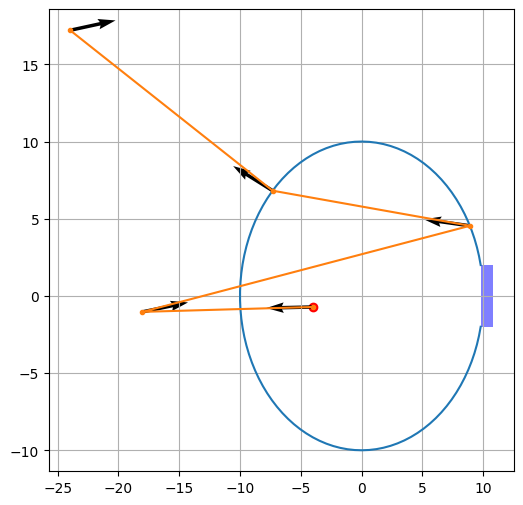

In [250]:
# Plot
fig0, ax0 = plt.subplots(figsize=(6,6))
ax0.plot(scint_radius*np.cos(theta_scint), scint_radius*np.sin(theta_scint))
r = random.uniform(0,2*np.pi)
maxdist = np.random.random()*scint_radius
random_track = (maxdist*np.cos(r), maxdist*np.sin(r)) # x, y
ax0.scatter(random_track[0],random_track[1], color='red', marker='o')
pmt_window = plt.Rectangle((x,y), length_pmt_window, width_pmt_window, fc='blue', alpha=0.5)
ax0.add_patch(pmt_window)
tracks = scintillator_monte_carlo(random_track[0],random_track[1], E=100, scint_radius=10, N_max=5, dt=0.2)
ax0.quiver(tracks[:,0],tracks[:,1], tracks[:,2], tracks[:,3],scale=10)
ax0.plot(tracks[:,0],tracks[:,1], color='C1', marker='.')
ax0.grid(True)
plt.show()